In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from hydra.utils import instantiate
from hydra.experimental import initialize, compose
import omegaconf
from soundbay.inference import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load model and dataloader from config YAML

In [2]:
import os

In [ ]:
os.chdir('../soundbay/soundbay/')  # This is needed - compose works only from the source dir of the package

In [4]:
with initialize(config_path='../soundbay/soundbay/conf/'):
        cfg = compose(config_name="runs/main.yaml")

/home/noam/venv/whale/lib/python3.8/site-packages/hydra/core/utils.py:146: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver(name, f)


In [5]:
val_dataset = instantiate(cfg.data.val_dataset)

/home/noam/venv/whale/lib/python3.8/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [6]:
model = instantiate(cfg.model.model)

/home/noam/venv/whale/lib/python3.8/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


## Load model state from checkpoint

In [7]:
ckpt_dict = torch.load('./outputs/2022-02-01/00-00-24/best.pth', map_location=torch.device('cuda'))

In [8]:
device = torch.device('cuda')

In [9]:
model.load_state_dict(ckpt_dict['model'])

<All keys matched successfully>

In [11]:
model = model.to(device)

In [12]:
model = model.eval()

## Create data loader from dataset

In [14]:
data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, num_workers=20, shuffle=True, pin_memory=True)

# Plot classification results

### function that returns arrays of labels and predictions 

In [15]:
def preds_and_labels(model, dataloader):
    y_true = []
    y_pred = []
    for batch in data_loader:
        pred = model(batch[0].to(device)).detach().cpu().numpy()
        label = batch[1].cpu().numpy()
        y_pred.append(pred)
        y_true.append(label)
    return np.concatenate(y_true, axis=0), np.concatenate(y_pred, axis=0)

In [16]:
y_true, y_pred = preds_and_labels(model, data_loader)

### Plot distribution of proba values for class "call" (1) 

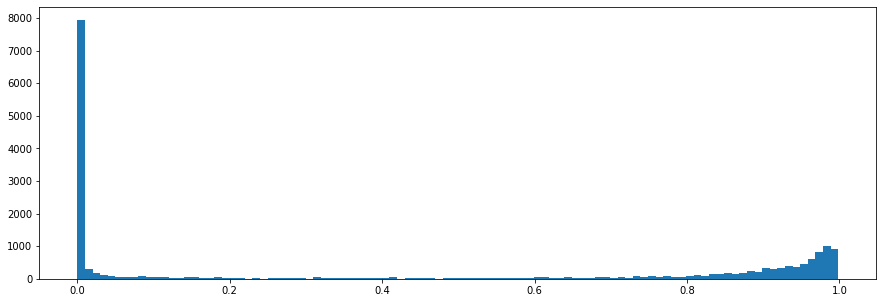

In [17]:
plt.figure(figsize=(15, 5))
plt.hist(torch.nn.Softmax(dim=1)(torch.Tensor(y_pred)).numpy()[:, 1], bins=100)
plt.show()

### Plot confuion matrix for variety of classification thresholds

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

In [23]:
def conf_matrix(y_true, y_pred, threshold=0.5):
    return ConfusionMatrixDisplay.from_predictions(y_true, torch.nn.Softmax(dim=1)(torch.Tensor(y_pred)).numpy()[:, 1] > threshold, labels=[0, 1])

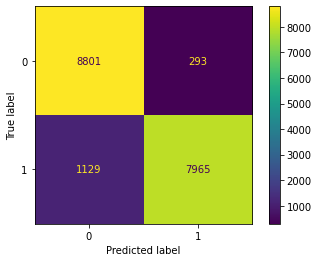

In [24]:
conf_mat = conf_matrix(y_true, y_pred)

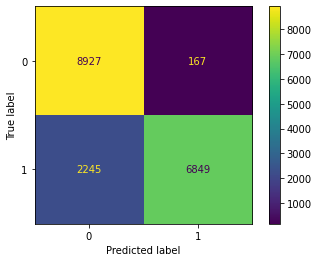

In [25]:
conf_mat = conf_matrix(y_true, y_pred, threshold=0.8)

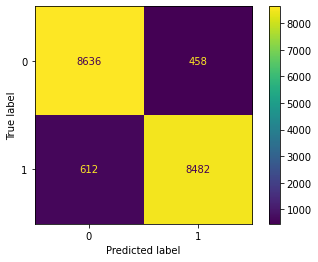

In [26]:
conf_mat = conf_matrix(y_true, y_pred, threshold=0.2)

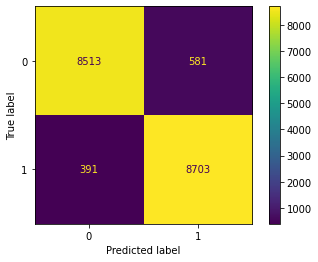

In [27]:
conf_mat = conf_matrix(y_true, y_pred, threshold=0.1)

# Plot data, labels and predictions for couple of images in the first batch

In [28]:
batch = next(iter(data_loader))

In [29]:
pred = model(batch[0].to(device)).argmax(axis=1).cpu().numpy()

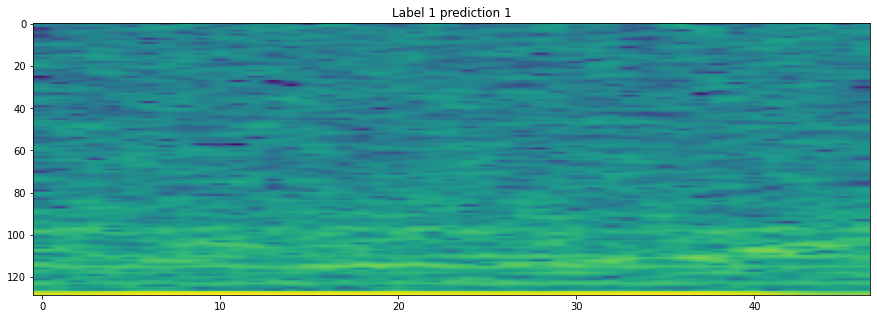

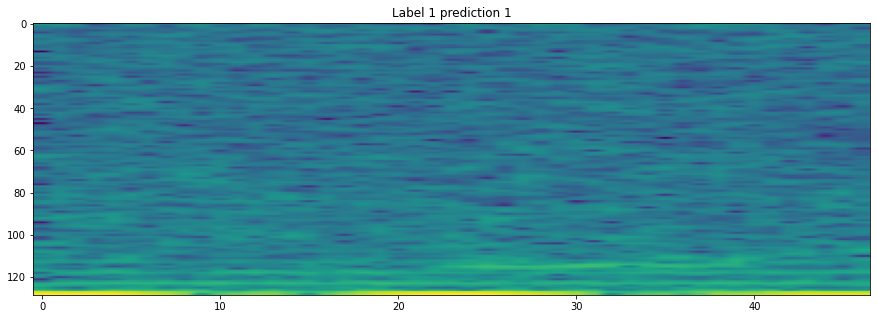

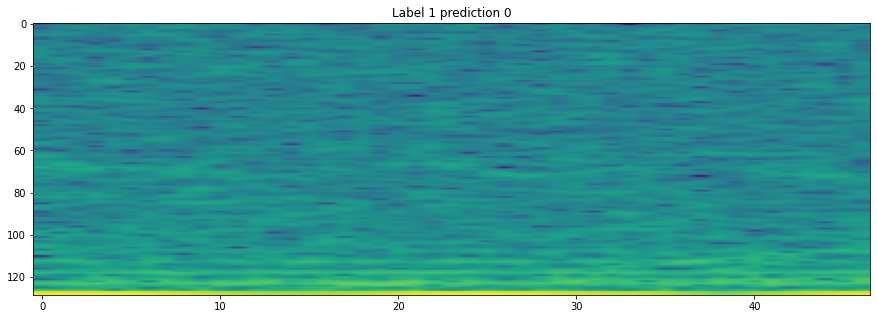

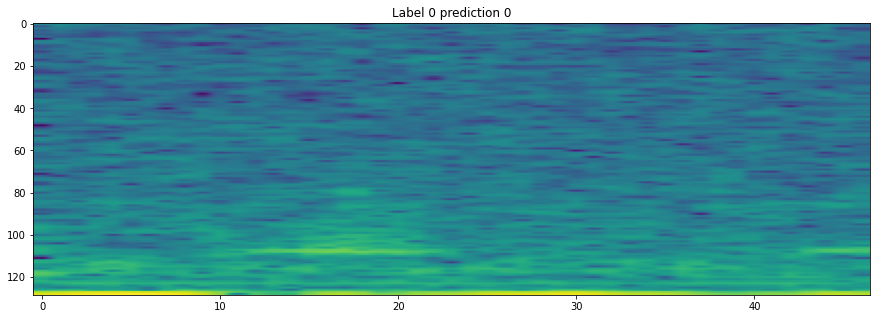

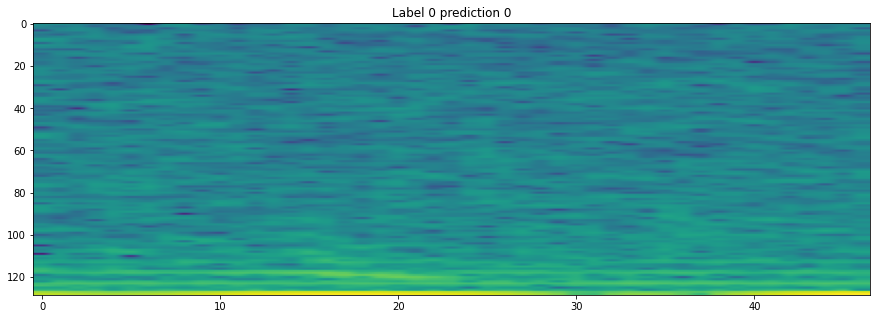

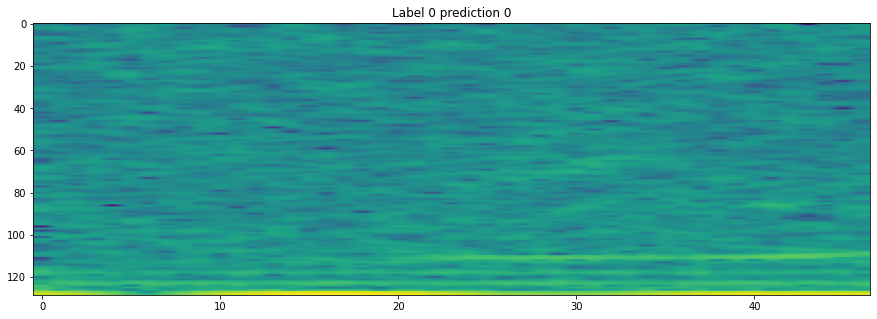

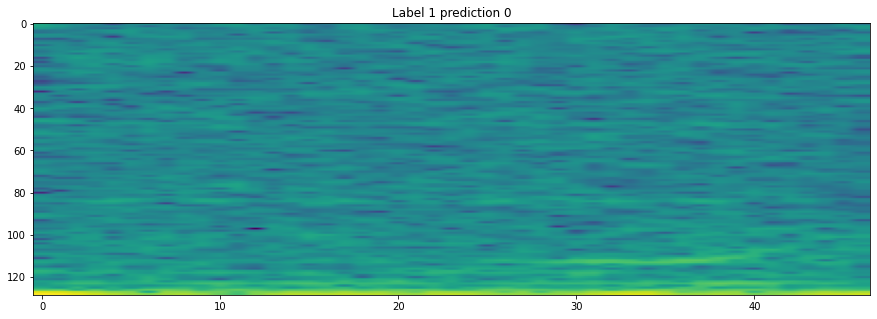

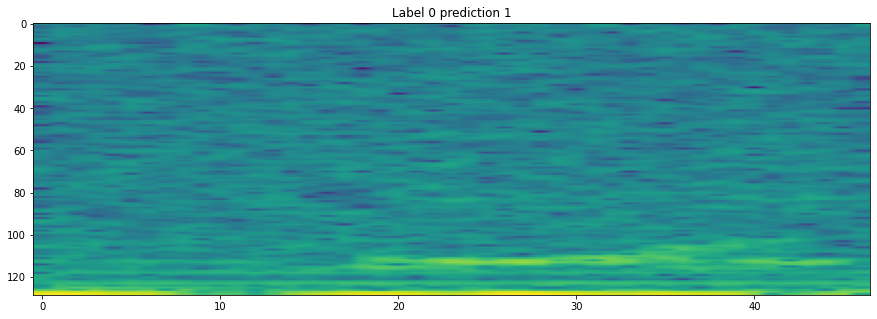

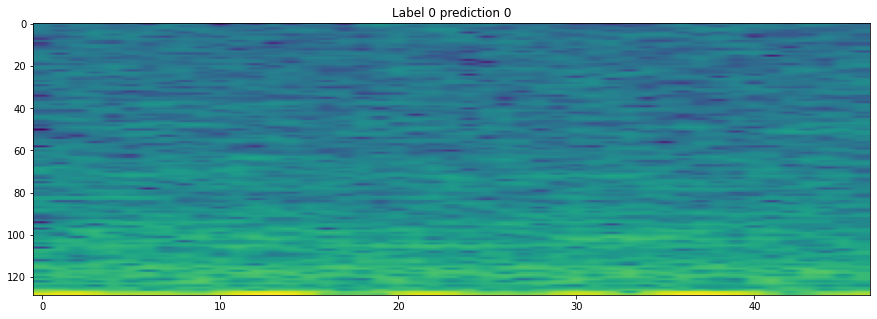

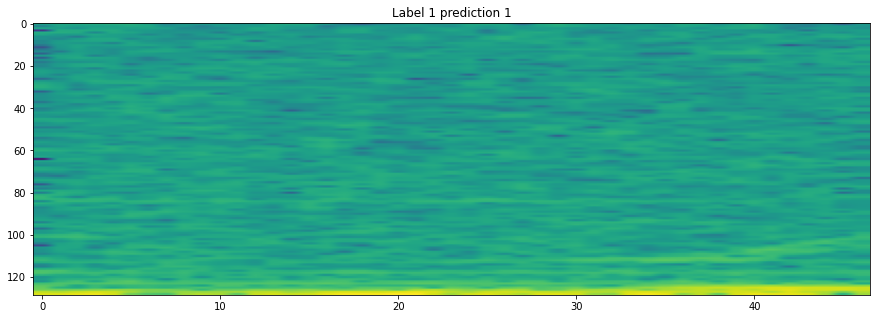

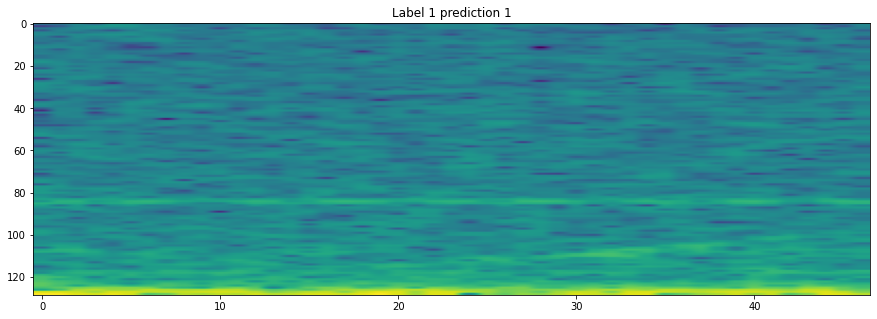

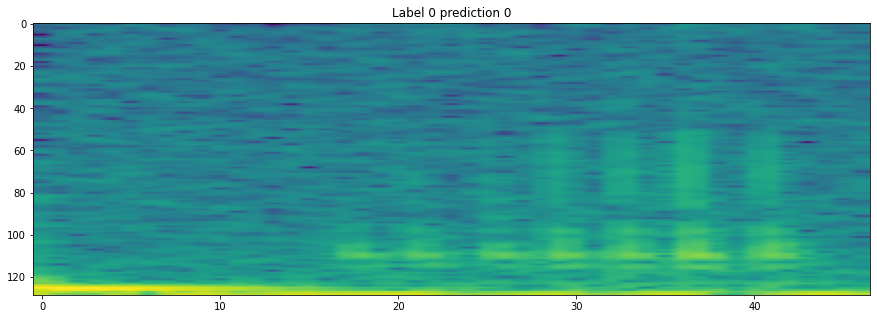

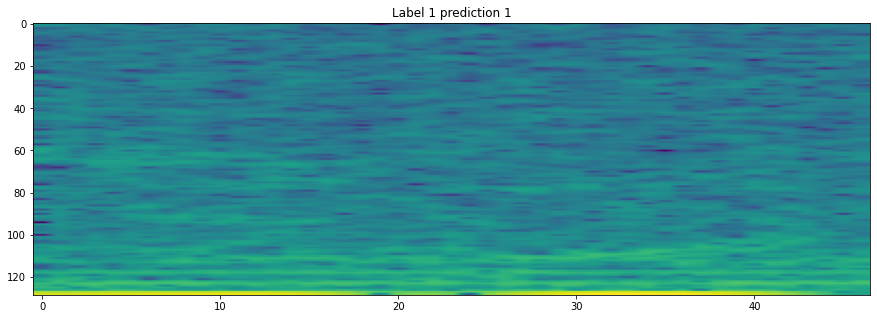

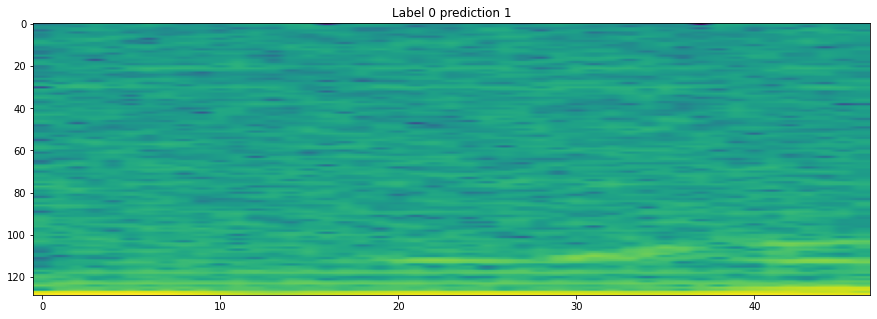

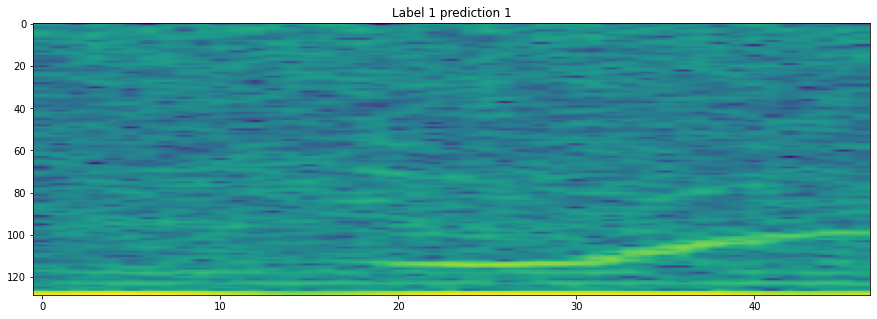

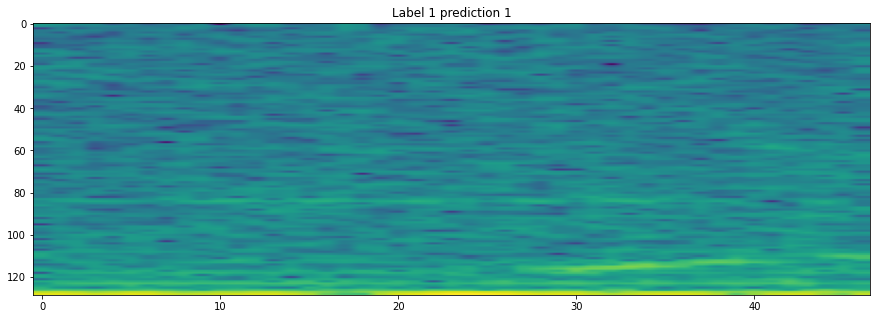

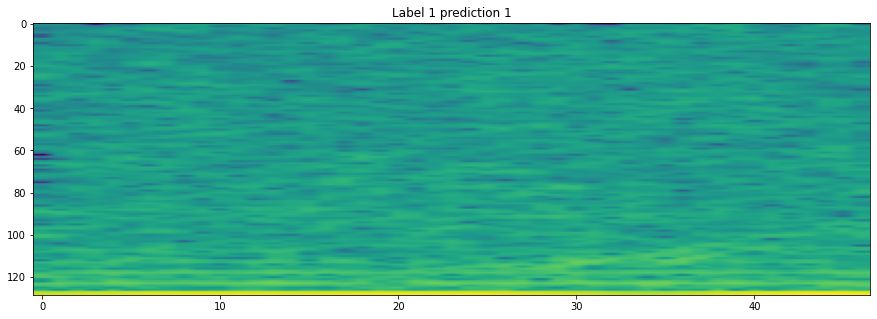

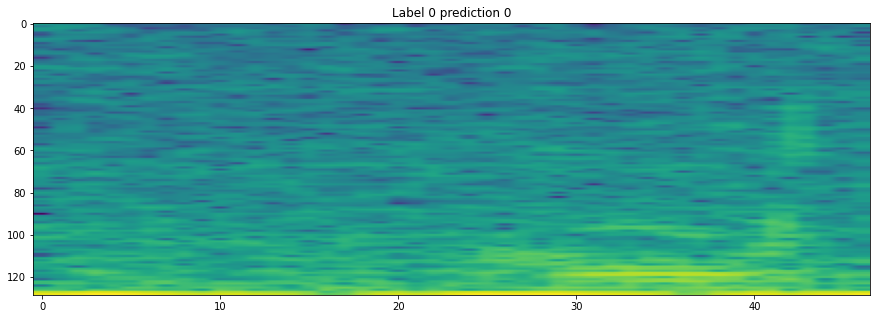

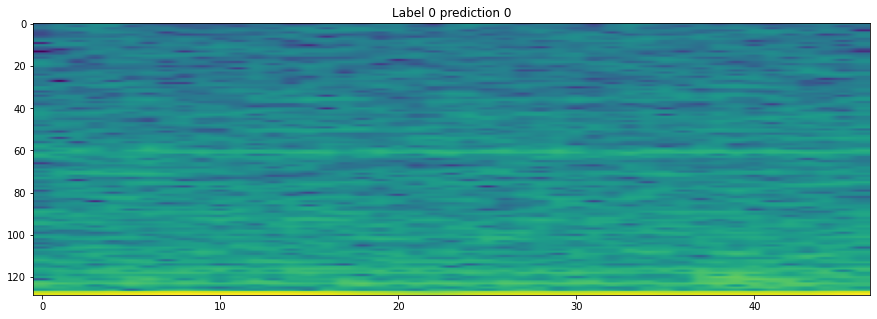

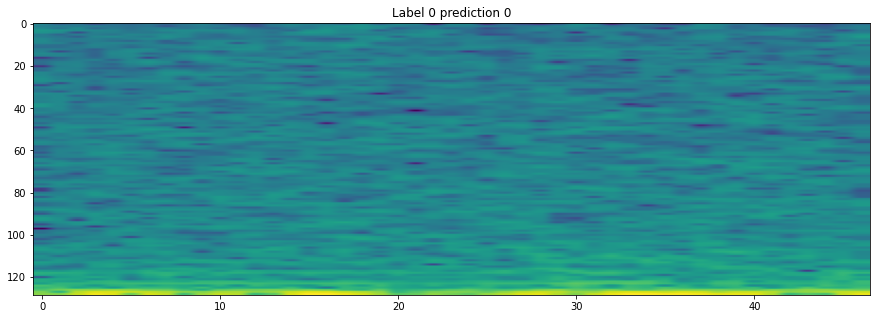

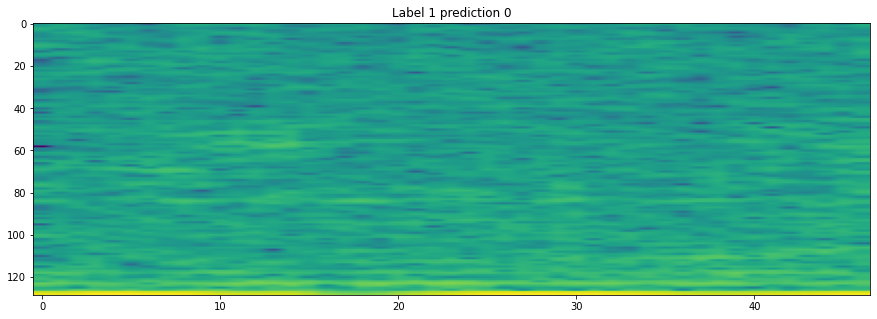

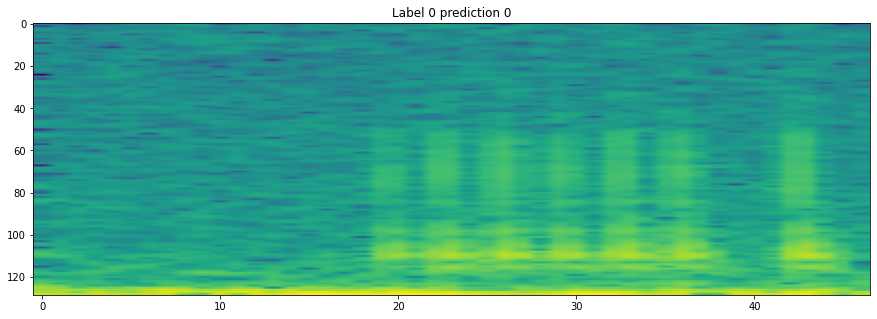

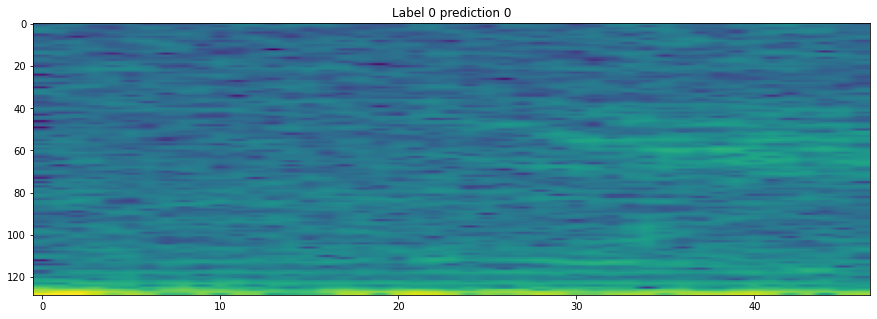

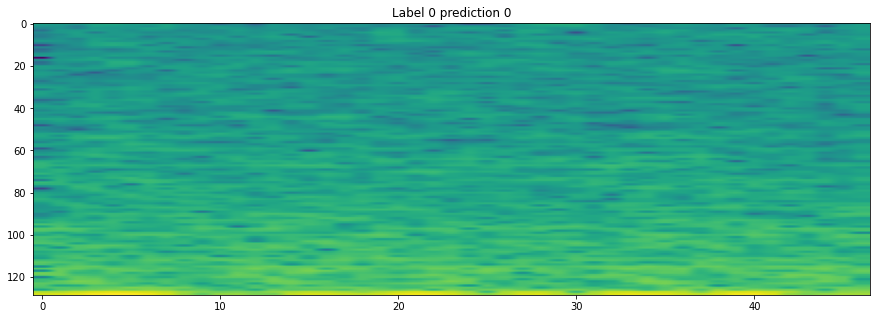

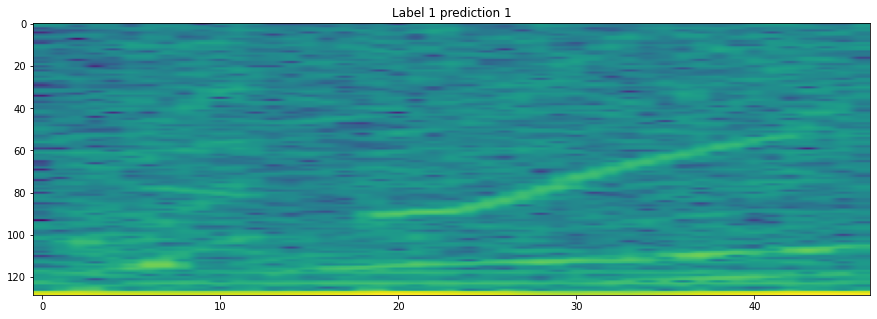

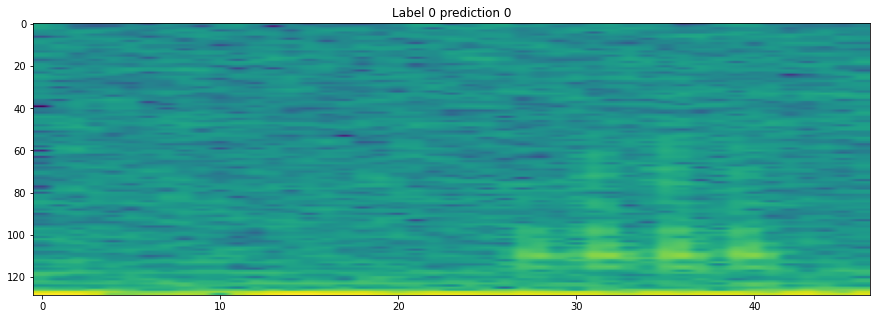

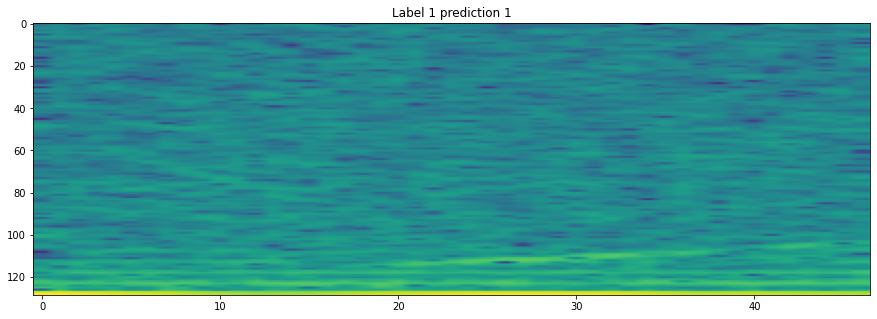

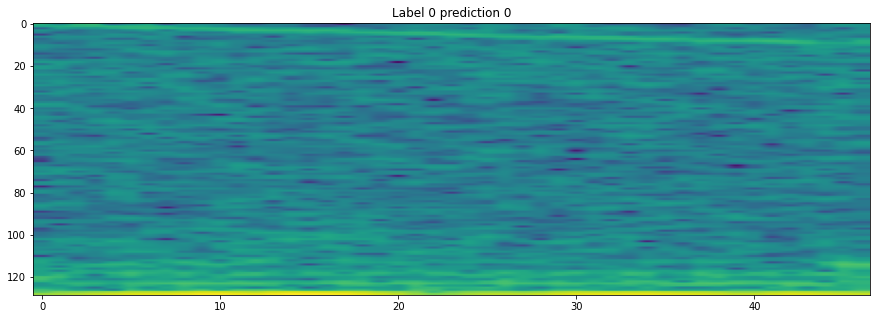

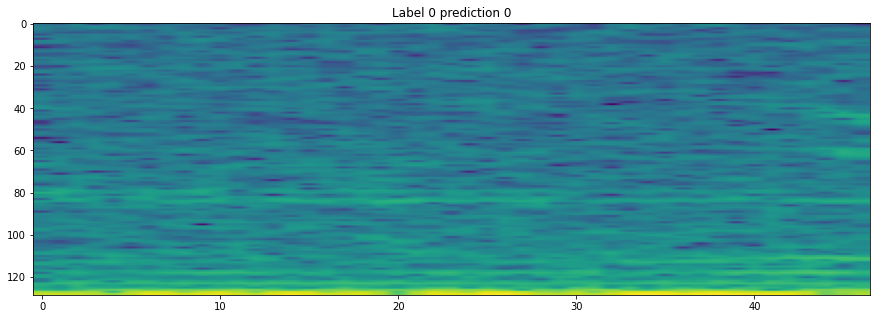

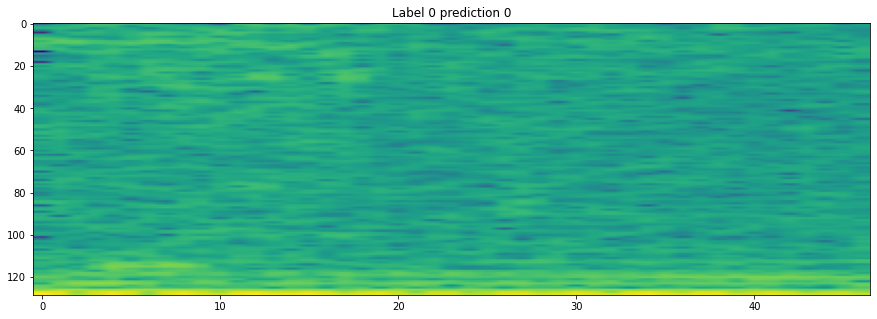

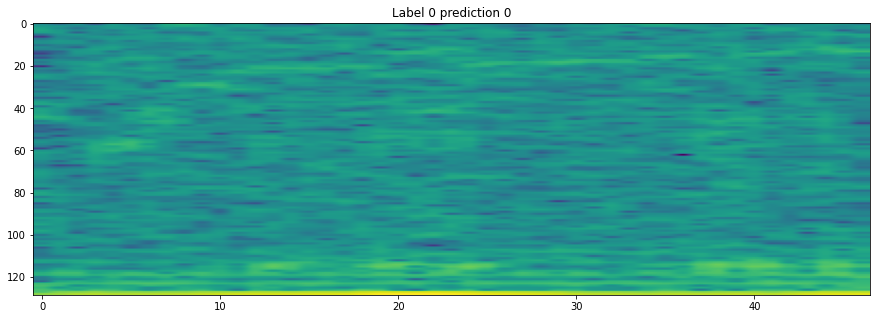

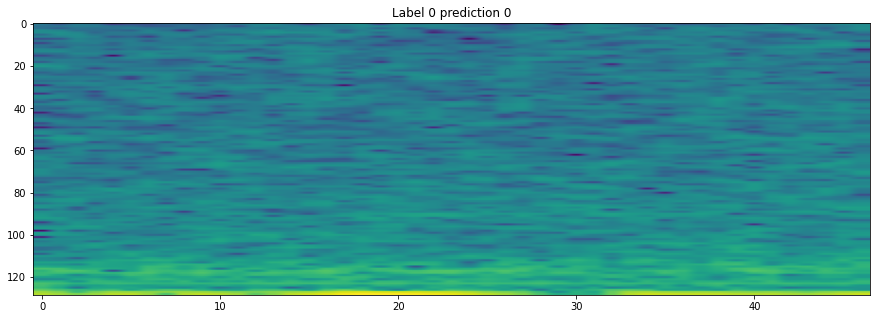

In [34]:
for i in range(min(len(batch[1]), 32)):
    plt.figure(figsize=(15,5))
    plt.imshow(batch[0][i][0].flipud(), aspect='auto')
    plt.title(f'Label {batch[1][i].numpy()} prediction {pred[i]}')
    plt.show()